In [1]:
# Step 1 - Imports
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [41]:
import pandas as pd

# Example: load Tox21 dataset (replace with your file path)
data = pd.read_csv("C:/Users/jaisica/Downloads/tox21 (1).csv")

print("Dataset shape:", data.shape)
print("Columns:", data.columns[:10])  # show first few columns

Dataset shape: (7831, 14)
Columns: Index(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
       'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE'],
      dtype='object')


In [11]:
# Step 2 - Safe Feature Extraction Function

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import RDLogger

# Disable RDKit warnings (like "not removing hydrogen atom without neighbors")
RDLogger.DisableLog('rdApp.warning')

def mol_to_features(smiles):
    """
    Convert SMILES string → molecular descriptors.
    Handles invalid molecules safely (returns None).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # skip invalid SMILES
    
    try:
        features = {
            # Basic descriptors
            "MolWt": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "TPSA": Descriptors.TPSA(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "RingCount": rdMolDescriptors.CalcNumRings(mol),
            "FractionCSP3": Descriptors.FractionCSP3(mol),

            # E-State descriptors
            "MaxAbsEStateIndex": Descriptors.MaxAbsEStateIndex(mol),
            "MinAbsEStateIndex": Descriptors.MinAbsEStateIndex(mol),
            "MaxEStateIndex": Descriptors.MaxEStateIndex(mol),
            "MinEStateIndex": Descriptors.MinEStateIndex(mol),

            # Other properties
            "HeavyAtomMolWt": Descriptors.HeavyAtomMolWt(mol),
            "ExactMolWt": Descriptors.ExactMolWt(mol),
            "NumValenceElectrons": Descriptors.NumValenceElectrons(mol),
            "qed": Descriptors.qed(mol)  # drug-likeness
        }
        return features
    except Exception as e:
        print(f"⚠️ Skipping {smiles} due to error: {e}")
        return None

# ✅ Quick test
print(mol_to_features("CCO"))   # Ethanol (valid)
print(mol_to_features("[H]"))   # Inv


{'MolWt': 46.069, 'LogP': -0.0014000000000000123, 'NumHDonors': 1, 'NumHAcceptors': 1, 'TPSA': 20.23, 'NumRotatableBonds': 0, 'RingCount': 0, 'FractionCSP3': 1.0, 'MaxAbsEStateIndex': 7.569444444444445, 'MinAbsEStateIndex': 0.25, 'MaxEStateIndex': 7.569444444444445, 'MinEStateIndex': 0.25, 'HeavyAtomMolWt': 40.021, 'ExactMolWt': 46.041864812, 'NumValenceElectrons': 20, 'qed': 0.4068079656553945}
{'MolWt': 1.008, 'LogP': 0.1125, 'NumHDonors': 0, 'NumHAcceptors': 0, 'TPSA': 0.0, 'NumRotatableBonds': 0, 'RingCount': 0, 'FractionCSP3': 0.0, 'MaxAbsEStateIndex': 0.0, 'MinAbsEStateIndex': 0.0, 'MaxEStateIndex': 0.0, 'MinEStateIndex': 0.0, 'HeavyAtomMolWt': 0.0, 'ExactMolWt': 1.007825032, 'NumValenceElectrons': 1, 'qed': 0.3426425581429387}


In [37]:
# Step 3 - Prepare features (sample 100 molecules, fixed index issue)

# Take only a small sample
sample_data = data.sample(100, random_state=42).reset_index(drop=True)

# Convert SMILES → descriptors
feature_data = sample_data["smiles"].apply(mol_to_features)

# Show how many failed
failed = feature_data.isna().sum()
print(f"❌ Molecules failed to featurize: {failed}")
print(f"✅ Molecules featurized: {len(feature_data) - failed}")

# Convert to DataFrame
feature_df = pd.DataFrame(list(feature_data))

print("📝 Feature DF shape before cleaning:", feature_df.shape)

# Drop rows with invalid features
valid_mask = feature_df.notna().all(axis=1)
feature_df = feature_df[valid_mask].reset_index(drop=True)
labels = sample_data.loc[valid_mask].reset_index(drop=True).drop(["smiles", "mol_id"], axis=1)

# Clean Inf/NaN
feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
feature_df = feature_df.dropna(axis=1, how="any")

print("✅ Features ready:", feature_df.shape)
print("✅ Labels ready:", labels.shape)

# Show first 5 rows
print(feature_df.head())


❌ Molecules failed to featurize: 0
✅ Molecules featurized: 100
📝 Feature DF shape before cleaning: (100, 16)
✅ Features ready: (100, 16)
✅ Labels ready: (100, 12)
     MolWt     LogP  NumHDonors  NumHAcceptors    TPSA  NumRotatableBonds  \
0   75.067 -0.97030           2              2   63.32                  1   
1  184.279  3.07610           0              2   26.30                  8   
2  156.269  2.75130           1              1   20.23                  5   
3  770.938  6.00344           2             14  196.82                 19   
4  195.306  2.23160           0              2   20.31                  2   

   RingCount  FractionCSP3  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          0      0.500000           9.243056           0.277778   
1          0      0.727273          10.606712           0.311520   
2          0      0.800000           8.629773           0.329353   
3          4      0.263158          12.774064           0.010240   
4          2      0.916667        

In [39]:
# Step 3b - Batch process full dataset safely

batch_size = 1000  # process 1000 molecules at a time
all_features = []
all_labels = []

# Loop through dataset in chunks
for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data.iloc[start:end].reset_index(drop=True)

    print(f"⚡ Processing rows {start} → {end}")

    # Convert SMILES → descriptors
    feature_data = batch["smiles"].apply(mol_to_features)
    feature_df = pd.DataFrame(list(feature_data))

    # Keep only valid molecules
    valid_mask = feature_df.notna().all(axis=1)
    feature_df = feature_df[valid_mask].reset_index(drop=True)
    label_batch = batch.loc[valid_mask].reset_index(drop=True).drop(["smiles", "mol_id"], axis=1)

    # Clean Inf/NaN
    feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
    feature_df = feature_df.dropna(axis=1, how="any")

    # Save batch results
    all_features.append(feature_df)
    all_labels.append(label_batch)

# Combine all batches
final_features = pd.concat(all_features, axis=0).reset_index(drop=True)
final_labels = pd.concat(all_labels, axis=0).reset_index(drop=True)

print("✅ Final Features shape:", final_features.shape)
print("✅ Final Labels shape:", final_labels.shape)

# Peek at descriptors
print(final_features.head())


⚡ Processing rows 0 → 1000
⚡ Processing rows 1000 → 2000
⚡ Processing rows 2000 → 3000
⚡ Processing rows 3000 → 4000
⚡ Processing rows 4000 → 5000
⚡ Processing rows 5000 → 6000
⚡ Processing rows 6000 → 7000
⚡ Processing rows 7000 → 8000
✅ Final Features shape: (7831, 16)
✅ Final Labels shape: (7831, 12)
     MolWt     LogP  NumHDonors  NumHAcceptors    TPSA  NumRotatableBonds  \
0  258.324  1.34240           1              5   82.28                  3   
1  204.229  1.29940           1              2   49.41                  2   
2  288.475  5.09030           1              1   20.23                  1   
3  276.424  3.75244           1              2   32.34                  7   
4  206.027 -0.99220           5              3  135.29                  2   

   RingCount  FractionCSP3  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          2      0.222222          11.107593           0.073011   
1          2      0.272727          11.790004           0.172500   
2          4      0.900000  

In [43]:
#Train/Test Split + Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and labels
X = final_features
y = final_labels

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Standardize descriptors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Train size: (6264, 16) Test size: (1567, 16)


In [45]:
#Train Models per Label


from sklearn.ensemble import RandomForestClassifier

models = {}

for col in y_train.columns:
    # Keep rows where this label is available
    mask = y_train[col].notna()
    X_label = X_train[mask]
    y_label = y_train[col][mask]

    if len(y_label) == 0:
        continue  # skip empty labels

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_label, y_label)

    models[col] = rf
    print(f"✅ Trained model for {col}")


✅ Trained model for NR-AR
✅ Trained model for NR-AR-LBD
✅ Trained model for NR-AhR
✅ Trained model for NR-Aromatase
✅ Trained model for NR-ER
✅ Trained model for NR-ER-LBD
✅ Trained model for NR-PPAR-gamma
✅ Trained model for SR-ARE
✅ Trained model for SR-ATAD5
✅ Trained model for SR-HSE
✅ Trained model for SR-MMP
✅ Trained model for SR-p53


In [47]:
#We evaluate each trained model on its corresponding toxicity task
from sklearn.metrics import classification_report

for col, model in models.items():
    mask = y_test[col].notna()
    X_test_label = X_test[mask]
    y_test_label = y_test[col][mask]

    if len(y_test_label) == 0:
        continue

    y_pred = model.predict(X_test_label)
    print(f"\n📊 Classification report for {col}:")
    print(classification_report(y_test_label, y_pred))



📊 Classification report for NR-AR:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1378
         1.0       0.92      0.38      0.53        61

    accuracy                           0.97      1439
   macro avg       0.95      0.69      0.76      1439
weighted avg       0.97      0.97      0.97      1439


📊 Classification report for NR-AR-LBD:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1311
         1.0       0.77      0.40      0.53        42

    accuracy                           0.98      1353
   macro avg       0.88      0.70      0.76      1353
weighted avg       0.97      0.98      0.97      1353


📊 Classification report for NR-AhR:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1140
         1.0       0.79      0.34      0.48       167

    accuracy                           0.90      1307
   macro avg   

C:\Users\jaisica\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jaisica\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jaisica\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Classification report for SR-ATAD5:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1350
         1.0       0.25      0.02      0.03        58

    accuracy                           0.96      1408
   macro avg       0.60      0.51      0.51      1408
weighted avg       0.93      0.96      0.94      1408


📊 Classification report for SR-HSE:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1227
         1.0       0.75      0.08      0.15        74

    accuracy                           0.95      1301
   macro avg       0.85      0.54      0.56      1301
weighted avg       0.94      0.95      0.93      1301


📊 Classification report for SR-MMP:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       991
         1.0       0.76      0.53      0.62       179

    accuracy                           0.90      1170
   macro avg   

In [53]:
def predict_toxicity(smiles, models):
    """
    Predict toxicity probabilities for a given SMILES.
    Returns dictionary of assay → probability.
    """
    # Convert SMILES → descriptors
    features = mol_to_features(smiles)
    if features is None:
        return None, "❌ Invalid SMILES string."

    X_new = pd.DataFrame([features])

    results = {}
    for col, model in models.items():
        # Align with training features
        X_new = X_new.reindex(columns=final_features.columns, fill_value=0)
        prob = model.predict_proba(X_new)[0][1] * 100  # toxic probability %
        results[col] = round(prob, 2)

    return results, "✅ Prediction successful"


In [67]:
def conclude_toxicity(compound_name, probabilities, threshold=50, min_toxic_assays=3):
    conclusions = []
    toxic_endpoints = []

    # Check each assay
    for assay, prob in probabilities.items():
        if prob >= threshold:
            conclusions.append(f"⚠️ {assay}: {prob}% → TOXIC")
            toxic_endpoints.append(assay)
        else:
            conclusions.append(f"✅ {assay}: {prob}% → NON-TOXIC")

    # Overall rule (>=3 toxic assays → TOXIC)
    if len(toxic_endpoints) >= min_toxic_assays:
        overall = (f"⚠️ {compound_name} is predicted TOXIC overall "
                   f"(toxic in {len(toxic_endpoints)} assays, rule = ≥{min_toxic_assays})")
    else:
        overall = (f"✅ {compound_name} is predicted NON-TOXIC overall "
                   f"(toxic in {len(toxic_endpoints)} assays, rule = ≥{min_toxic_assays})")

    return overall, conclusions, toxic_endpoints


In [71]:
import matplotlib.pyplot as plt

def plot_toxicity_results(compound_name, probabilities, toxic_endpoints, overall, threshold=50, min_toxic_assays=3):
    assays = list(probabilities.keys())
    values = list(probabilities.values())

    # Color bars red if toxic, green if non-toxic
    colors = ["red" if assay in toxic_endpoints else "green" for assay in assays]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(assays, values, color=colors, alpha=0.8)

    # Threshold line
    plt.axhline(y=threshold, color="blue", linestyle="--", linewidth=1, label=f"Threshold = {threshold}%")

    # Add bar labels
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{val:.1f}%", ha="center", va="bottom", fontsize=8)

    # Add overall conclusion on plot
    plt.text(0.5, 1.05, overall,
             ha="center", va="bottom", fontsize=12, fontweight="bold", color="black", transform=plt.gca().transAxes)

    # Title and labels
    plt.title(f"Toxicity Prediction for {compound_name}\nRule: TOXIC if ≥ {min_toxic_assays} assays cross threshold",
              fontsize=14, fontweight="bold")
    plt.ylabel("Predicted Toxicity Probability (%)")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


✅ Aspirin is predicted NON-TOXIC overall (toxic in 1 assays, rule = ≥3)
✅ NR-AR: 45.0% → NON-TOXIC
✅ NR-AR-LBD: 37.0% → NON-TOXIC
✅ NR-AhR: 25.0% → NON-TOXIC
✅ NR-Aromatase: 24.0% → NON-TOXIC
✅ NR-ER: 28.67% → NON-TOXIC
✅ NR-ER-LBD: 38.0% → NON-TOXIC
✅ NR-PPAR-gamma: 25.0% → NON-TOXIC
✅ SR-ARE: 45.5% → NON-TOXIC
✅ SR-ATAD5: 30.5% → NON-TOXIC
✅ SR-HSE: 16.5% → NON-TOXIC
⚠️ SR-MMP: 53.5% → TOXIC
✅ SR-p53: 23.5% → NON-TOXIC


C:\Users\jaisica\AppData\Local\Temp\ipykernel_16028\3162133717.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\jaisica\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


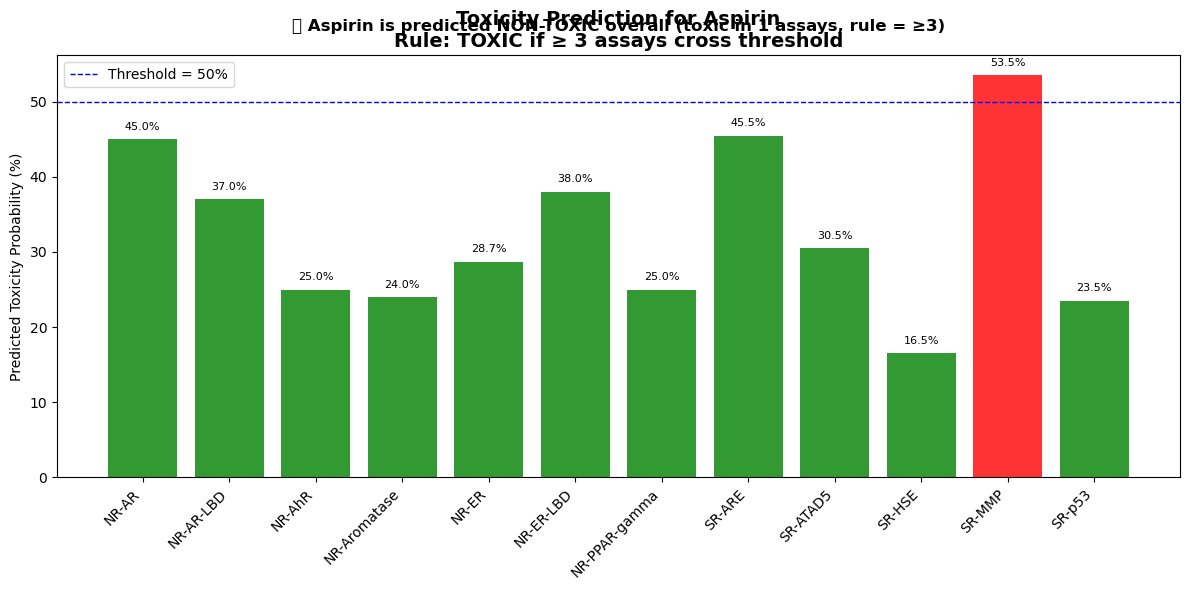

In [75]:
# Example predicted probabilities (from your model for Aspirin)
probabilities = {
    'NR-AR': 45.0, 'NR-AR-LBD': 37.0, 'NR-AhR': 25.0, 
    'NR-Aromatase': 24.0, 'NR-ER': 28.67, 'NR-ER-LBD': 38.0, 
    'NR-PPAR-gamma': 25.0, 'SR-ARE': 45.5, 'SR-ATAD5': 30.5, 
    'SR-HSE': 16.5, 'SR-MMP': 53.5, 'SR-p53': 23.5
}

compound_name = "Aspirin"

# Get conclusion
overall, conclusions, toxic_endpoints = conclude_toxicity(
    compound_name, probabilities, threshold=50, min_toxic_assays=3
)

# Print results
print(overall)
for c in conclusions:
    print(c)

# Plot results
plot_toxicity_results(compound_name, probabilities, toxic_endpoints, overall, threshold=50, min_toxic_assays=3)

